In [6]:
using CairoMakie
using NCDatasets
using Oceananigans
using TopographicHorizontalConvection: HorizontalConvectionSimulation

In [7]:
using Interpolations
using NaNStatistics

In [8]:
ds = NCDataset(string("/pub/hfdrake/code/HorizontalConvection/output/turbulent_h0.6_buoyancy.nc"))
#ds2 = NCDataset(string("/pub/hfdrake/code/HorizontalConvection/output/turbulent_h0.6_section_snapshots.nc"))
x = ds["xC"][4+1:end-4]; Nx = length(x);
y = ds["yC"][4+1:end-4]; Ny = length(y);
z = ds["zC"][4+1:end-4]; Nz = length(z);

In [9]:
Δx = reshape(diff(ds["xF"])[4+1:end-4], Nx,1,1);
Δy = reshape(diff(ds["yF"])[4+1:end-3], 1,Ny,1); # periodic in y so just left positions
Δz = reshape(diff(ds["zF"])[4+1:end-4], 1,1,Nz);

ΔA = Δx.*Δy;
ΔV = ΔA.*Δz;

In [10]:
function calc_zstar(b)
    
    wet = b.!=0.;
    b[.!wet] .= NaN;
    
    z_3d = repeat(reshape(z, 1,1,Nz), Nx, Ny, 1);
    b_flat = reshape(b, (Nx*Ny*Nz));
    wet_flat = reshape(wet, (Nx*Ny*Nz));
    z_flat = reshape(z_3d, (Nx*Ny*Nz));
    
    sort_idx = sortperm(b_flat);
    b_sorted, z_sorted = b_flat[sort_idx], z_flat[sort_idx];
    
    ΔV_flat = ΔV[sort_idx];
    
    A_wet = dropdims(sum(wet.*ΔA, dims=(1,2)), dims=(1,2));
    A_interpolation = linear_interpolation(z, A_wet, extrapolation_bc=Line());
    
    z_bot = ds["zF"][5] # ignore 4 halo points
    zstar_flat = zeros(size(b_sorted))
    zstar_flat[1] = z_bot
    for k in 2:length(b_sorted)
        A = A_interpolation(zstar_flat[k-1])
        if !isnan(b_sorted[k])
            zstar_flat[k] = zstar_flat[k-1] + ΔV_flat[k]/A
        else
            zstar_flat[k] = NaN
        end
    end
    
    unsort_idx = sortperm(sort_idx)
    zstar = reshape(zstar_flat[unsort_idx], size(b))

    return zstar
end


calc_zstar (generic function with 1 method)

In [11]:
#buoyancy snapshot at t=25 in order to find zstar at t=25
b = ds["b"][4+1:end-4, 4+1:end-4, 4+1:end-4, 4];

In [12]:
wet = b.!=0.; # This does not work for the initial timestep because our initial condition is that b==0 everywhere!

b[.!wet] .= NaN;

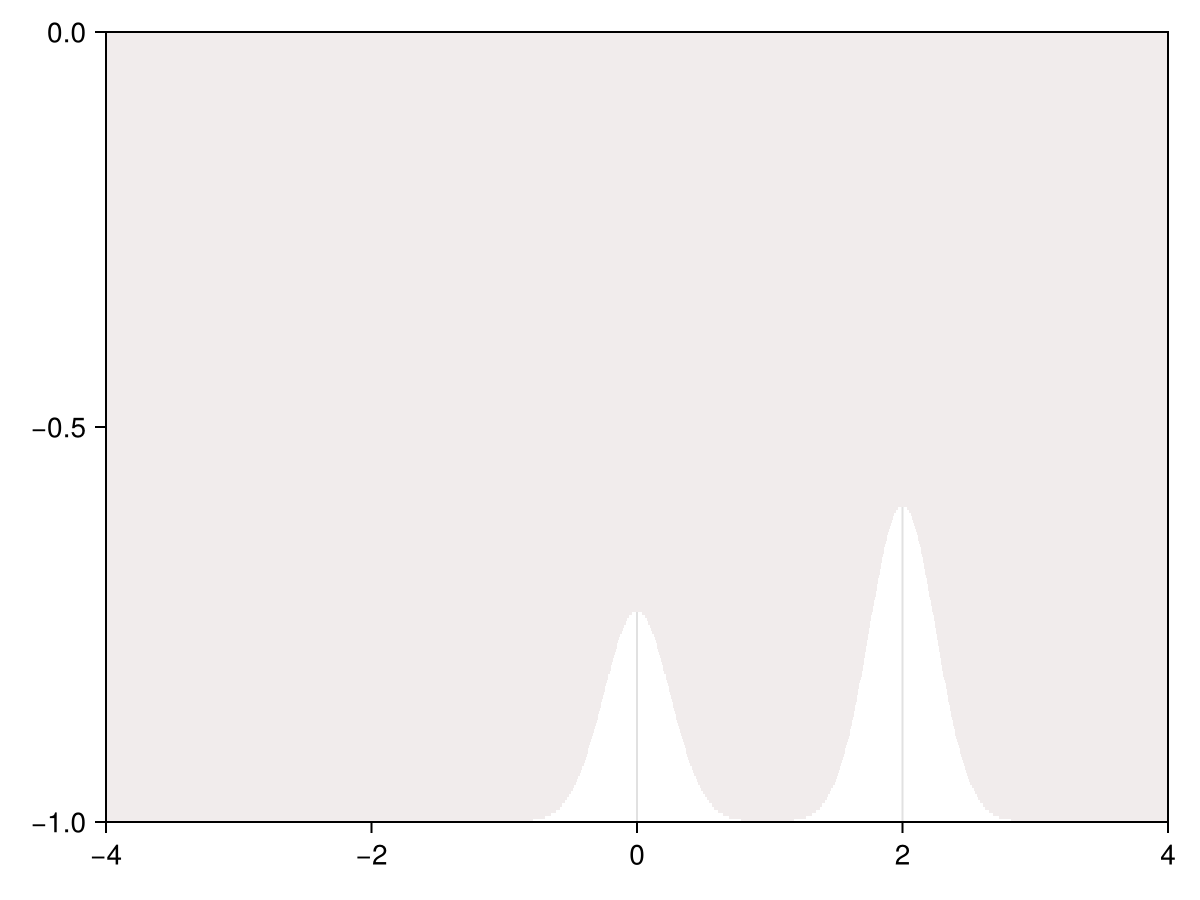

In [15]:
#initial time step
b0 = ds["b"][4+1:end-4, 4+1:end-4, 4+1:end-4, 1];
b0[.!wet] .= NaN
heatmap(ds["xC"][5:end-4], ds["zC"][5:end-4], b0[:,Ny÷2,:], colorrange=(-1.0, 1.0), colormap=:balance)
#heatmap(ds["xC"][5:end-4], ds["zC"][5:end-4], is_it_wet[:,Ny÷2,:], colorrange=(-1.0, 1.0), colormap=:turbid)

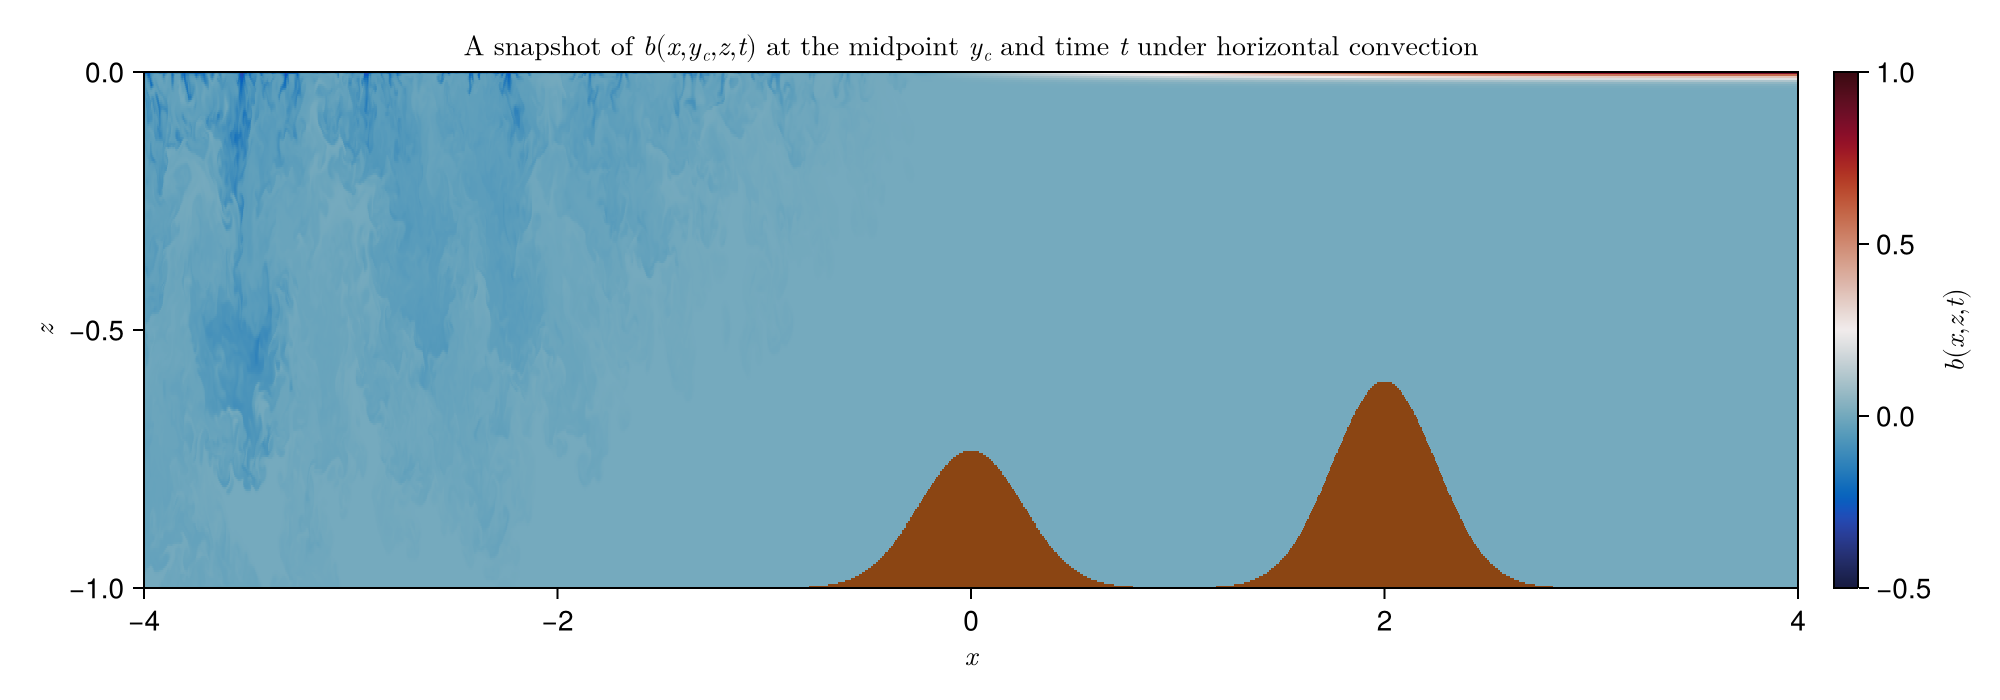

In [35]:
f = Figure(size=(1000, 350))
ax = Axis(f[1,1], xlabel=L"$x$", ylabel=L"$z$", title=L"A snapshot of $b(x,y_{c},z,t)$ at the midpoint $y_{c}$ and time $t$ under horizontal convection")
nan_color = :brown
hm = heatmap!(ax, ds["xC"][5:end-4], ds["zC"][5:end-4], b[:,Ny÷2,:], colorrange = (-0.5, 1.0), colormap = :balance, nan_color=:chocolate4)
Colorbar(f[1,2], hm, label=L"$b(x,z,t)$");
f

In [13]:
z_3d = repeat(reshape(z, 1,1,Nz), Nx, Ny, 1);

In [14]:
b_flat = reshape(b, (Nx*Ny*Nz));
wet_flat = reshape(wet, (Nx*Ny*Nz));
z_flat = reshape(z_3d, (Nx*Ny*Nz));

In [15]:
sort_idx = sortperm(b_flat);
b_sorted, z_sorted = b_flat[sort_idx], z_flat[sort_idx];

### Generalization of sorting method to variable grid spacing and immersed boundaries

The idea is that we reconstruct $z^{\star}$ by stacking elevation increments from each grid cell, working our way from the densest cells at the bottom of the ocean to the most buoyancy at the top. With this method, we can easily keep track of the volume taken up by each grid cell and divide that by the area of the ocean *at the resorted depth* $A(z^{\star})$! To compute $A(z^{\star})$, we fit an interpolator to the known $A(z)$ (integrating the wet mask in $x$ and $y$) and then interpolate to any given intermediary $z=z^{\star}$.

In [16]:
ΔA = Δx.*Δy;
ΔV = ΔA.*Δz;
ΔV_flat = ΔV[sort_idx];

In [17]:
A_wet = dropdims(sum(wet.*ΔA, dims=(1,2)), dims=(1,2));
A_interpolation = linear_interpolation(z, A_wet, extrapolation_bc=Line());

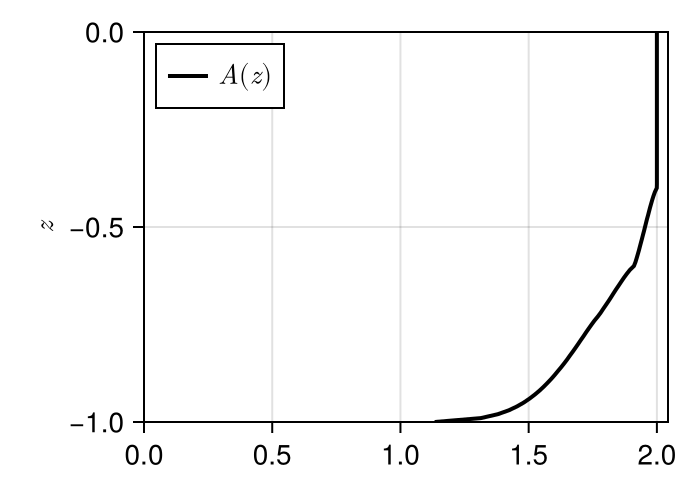

In [18]:
f = Figure(size=(350, 250))
ax = Axis(f[1,1], ylabel=L"$z$", limits=((0, nothing),(-1, 0)))
l = lines!(ax, A_interpolation(-1:0.01:0), collect(-1:0.01:0), linewidth=2, color=:black, label=L"$A(z)$")
axislegend(ax, position=:lt)
f

In [19]:
z_bot = ds["zF"][5] # ignore 4 halo points
zstar_flat = zeros(size(b_sorted))
zstar_flat[1] = z_bot
for k in 2:length(b_sorted)
    A = A_interpolation(zstar_flat[k-1])
    if !isnan(b_sorted[k])
        zstar_flat[k] = zstar_flat[k-1] + ΔV_flat[k]/A
    else
        zstar_flat[k] = NaN
    end
end

In [14]:
b̄ = dropdims(nanmean(b, dims=(1,2)), dims=(1,2)); # horizontal average

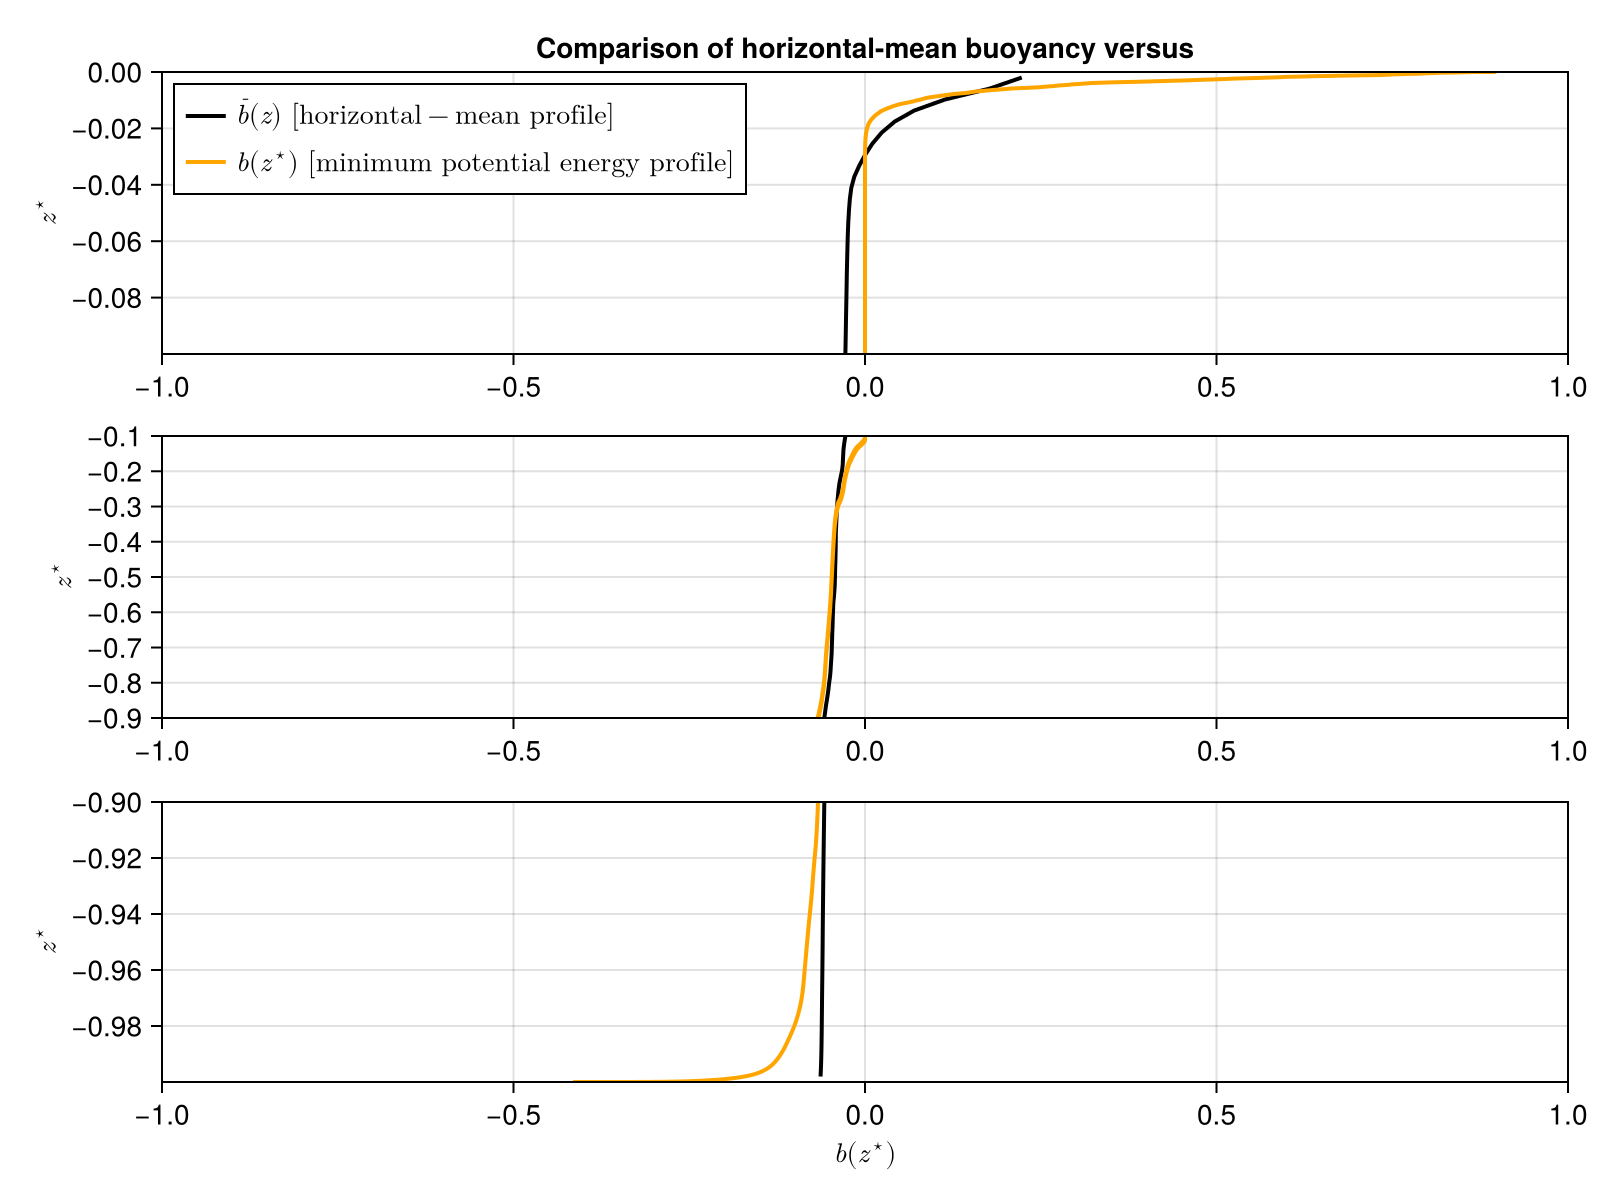

In [17]:
# Note: my kernel crashes if I try to plot the full reference profile b(z^star) because it is O(50 million) points, so I just show ever 100th of them
nskip = 100
f = Figure(size=(800, 600))
ax = Axis(f[1,1], ylabel=L"$z^{\star}$", limits=((-1, 1),(-0.1, 0)), title="Comparison of horizontal-mean buoyancy versus")
l = lines!(ax, b̄, z, linewidth=2, color=:black, label=L"$\overline{b}(z)$ [horizontal-mean profile]")
l = lines!(ax, b_sorted[1:nskip:end], zstar_flat[1:nskip:end], linewidth=2, color=:orange, label=L"$b(z^{\star})$ [minimum potential energy profile]")
axislegend(ax, position=:lt)
ax = Axis(f[2,1], ylabel=L"$z^{\star}$", limits=((-1, 1),(-0.9, -0.1)))
l = lines!(ax, b̄, z, linewidth=2, color=:black, label=L"$\overline{b}(z)$ [horizontal-mean profile]")
l = lines!(ax, b_sorted[1:nskip:end], zstar_flat[1:nskip:end], linewidth=2, color=:orange, label=L"$b(z^{\star})$ [minimum potential energy profile]")
ax = Axis(f[3,1], xlabel=L"$b(z^{\star})$", ylabel=L"$z^{\star}$", limits=((-1, 1),(-1, -0.9)))
l = lines!(ax, b̄, z, linewidth=2, color=:black, label=L"$\overline{b}(z)$ [horizontal-mean profile]")
l = lines!(ax, b_sorted[1:nskip:end], zstar_flat[1:nskip:end], linewidth=2, color=:orange, label=L"$b(z^{\star})$ [minimum potential energy profile]")
f

In [20]:
unsort_idx = sortperm(sort_idx);
zstar = reshape(zstar_flat[unsort_idx], size(b));

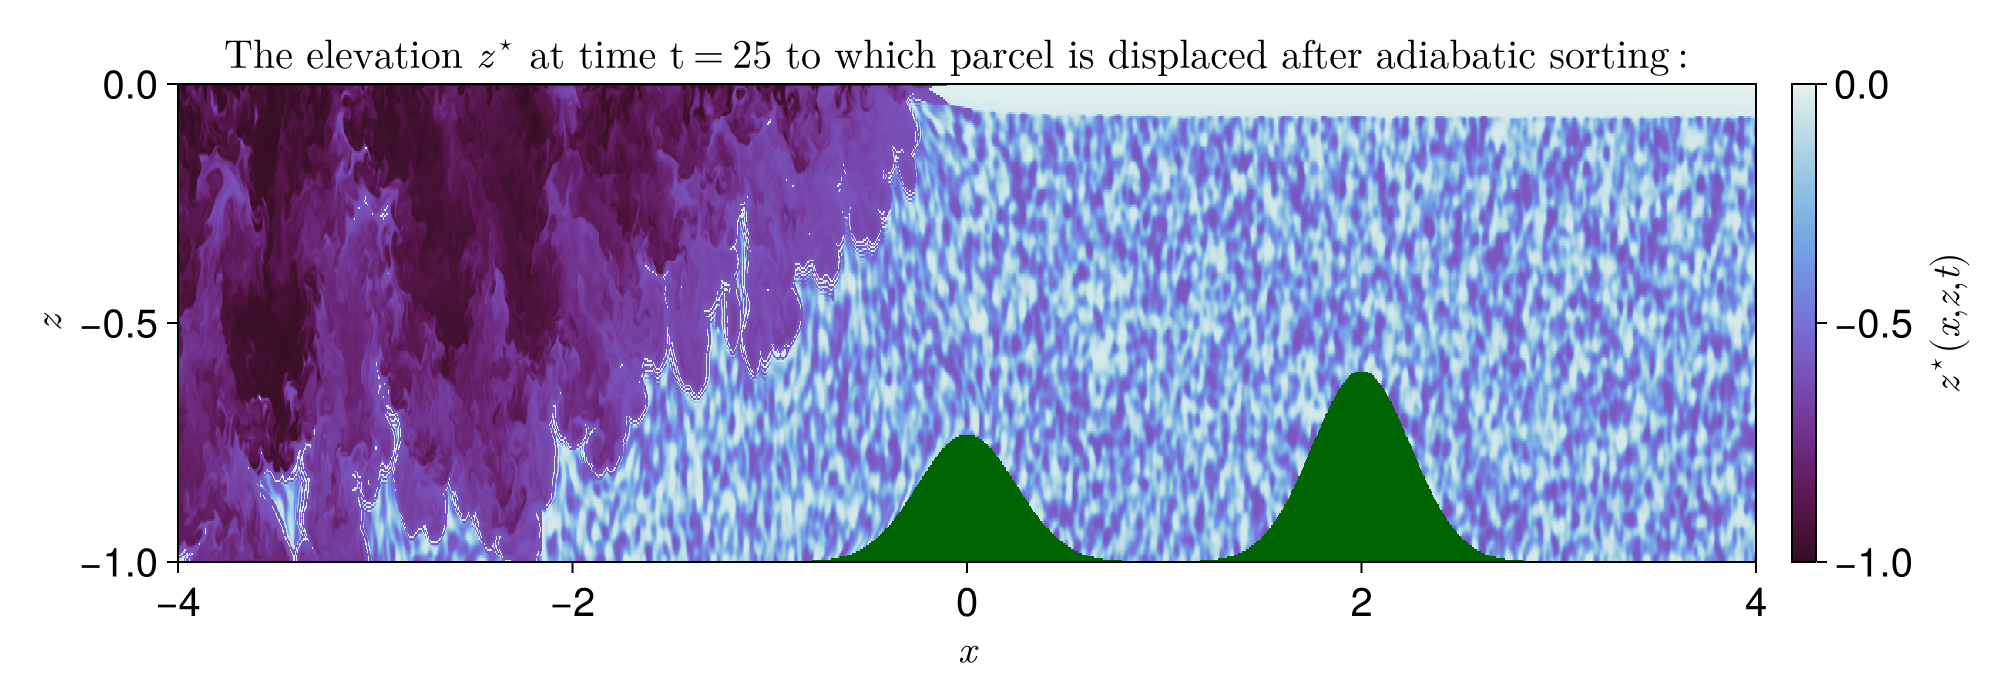

In [28]:
f = Figure(size=(1000, 350), fontsize=20)
ax = Axis(f[1,1], xlabel=L"$x$", ylabel=L"$z$", title=L"The elevation $z^{\star}$ at time t=25 to which parcel is displaced after adiabatic sorting: ")
hm = heatmap!(ax, ds["xC"][5:end-4], ds["zC"][5:end-4], zstar[:,Ny÷2,:], colorrange = (-1, 0), colormap = Reverse(:dense), nan_color = :darkgreen)
Colorbar(f[1,2], hm, label=L"$z^{\star}(x,z,t)$");
f

In [1]:
f = Figure(size=(1000, 350))
ax = Axis(f[1,1], xlabel=L"$x$", ylabel=L"$z$", title=L"The elevation $z^{\star}$ to which parcel is displaced after adiabatic sorting")
hm = heatmap!(ax, ds["xC"][5:end-4], ds["zC"][5:end-4], (zstar-z_3d)[:,Ny÷2,:], colorrange = (-1, 1), colormap = :balance, nan_color=:darkgreen)
Colorbar(f[1,2], hm, label=L"$z^{\star}(x,z,t)-z$");
f

LoadError: UndefVarError: `Figure` not defined

In [ ]:
b_times = ds["b"][4+1:end-4, 4+1:end-4, 4+1:end-4, :];
z_broadcast = reshape(z,(1,1,Nz));

size(zstar[1:nskip:end, :, :])

In [33]:
ΔV = 5.960464477539063e-8
nskip = 100
#potential_energy_offline = sum(-b_times[1:nskip:end, :, :, :] .* z_broadcast .* ΔV, dims=(1,2,3))[1,1,1,:];

background_PE_snap = zeros(size(b_times,4))

for i in 1:size(b_times,4)

    zstar_snap[i] = 
    background_PE_snap[i]= sum(-b_times[:, :, :, i] .* zstar[ .* ΔV, dims=(1,2,3))
    
    

print(background_potential_energy_offline)

[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]

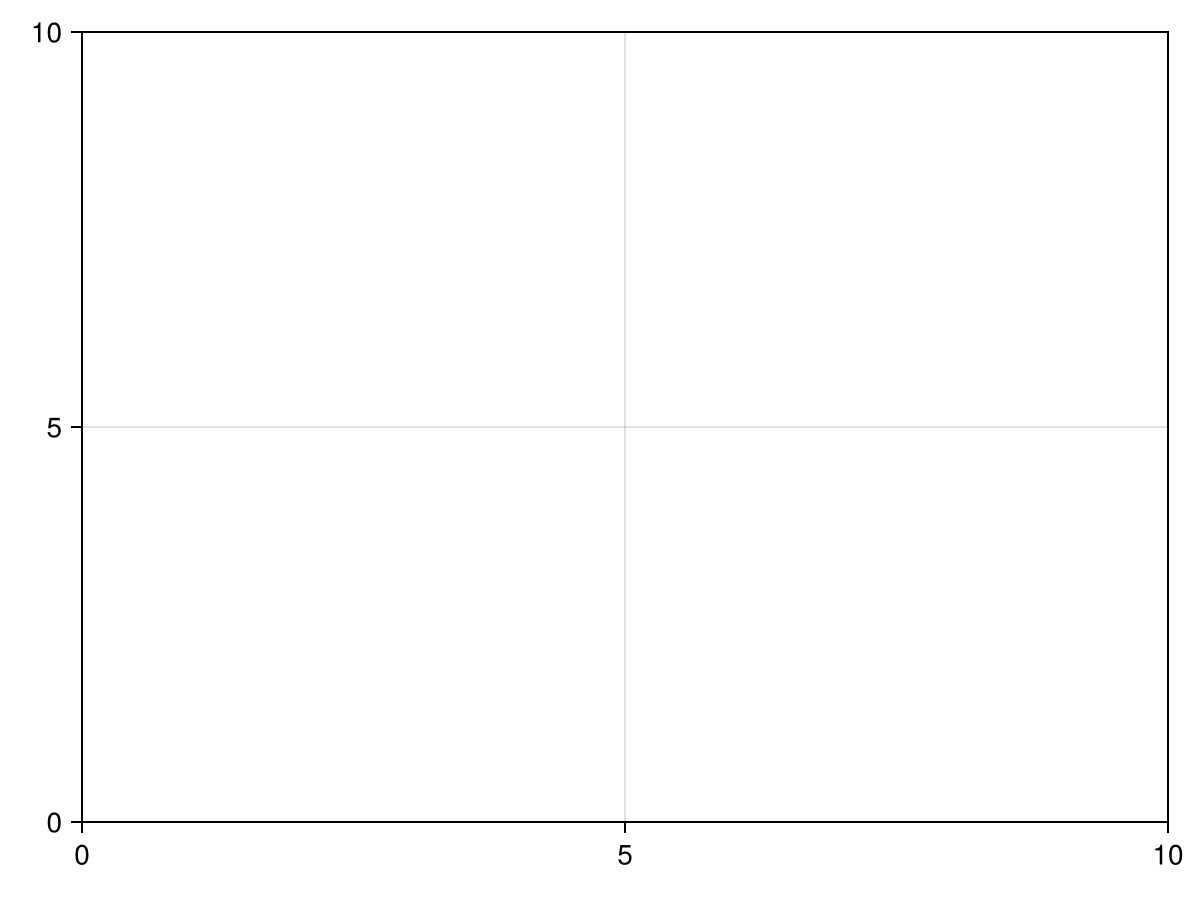

In [32]:
times = ds["time"][:]

#lines(times, potential_energy_offline)
lines(times, background_potential_energy_offline)

In [23]:
b_flat_sorted = b_flat[sort_idx]
b_ref = zeros(size(b));
n = 1
for k in 1:Nz
    for j in 1:Ny
        for i in 1:Nx
            b_new = b_flat_sorted[n]
            if wet[i,j,k]
                b_ref[i,j,k] = b_new
                n+=1
            else
                b_ref[i,j,k] = NaN
            end
        end
    end
end

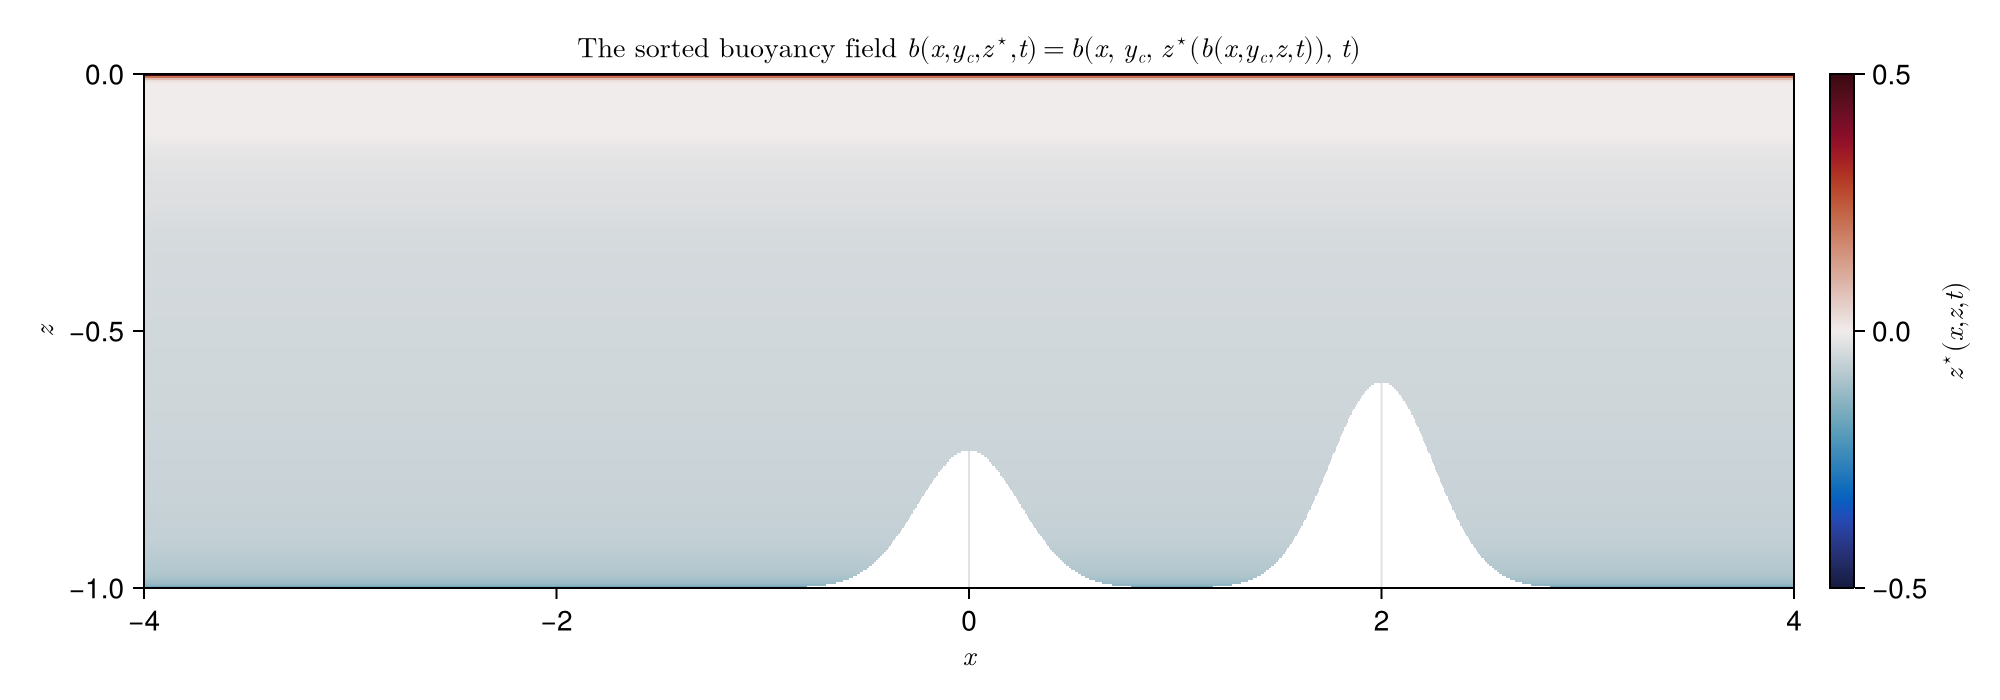

In [24]:
f = Figure(size=(1000, 350))
ax = Axis(f[1,1], xlabel=L"$x$", ylabel=L"$z$", title=L"The sorted buoyancy field $b(x,y_{c},z^{\star},t) = b(x,\; y_{c},\; z^{\star}(b(x,y_{c},z,t)),\;  t)$")
hm = heatmap!(ax, ds["xC"][5:end-4], ds["zC"][5:end-4], b_ref[:,Ny÷2,:], colorrange = (-0.5, 0.5), colormap = :balance)
Colorbar(f[1,2], hm, label=L"$z^{\star}(x,z,t)$");
f

In [25]:
b̄_ref = repeat(nanmean(b_ref, dims=(1,2)), Nx, Ny, 1);

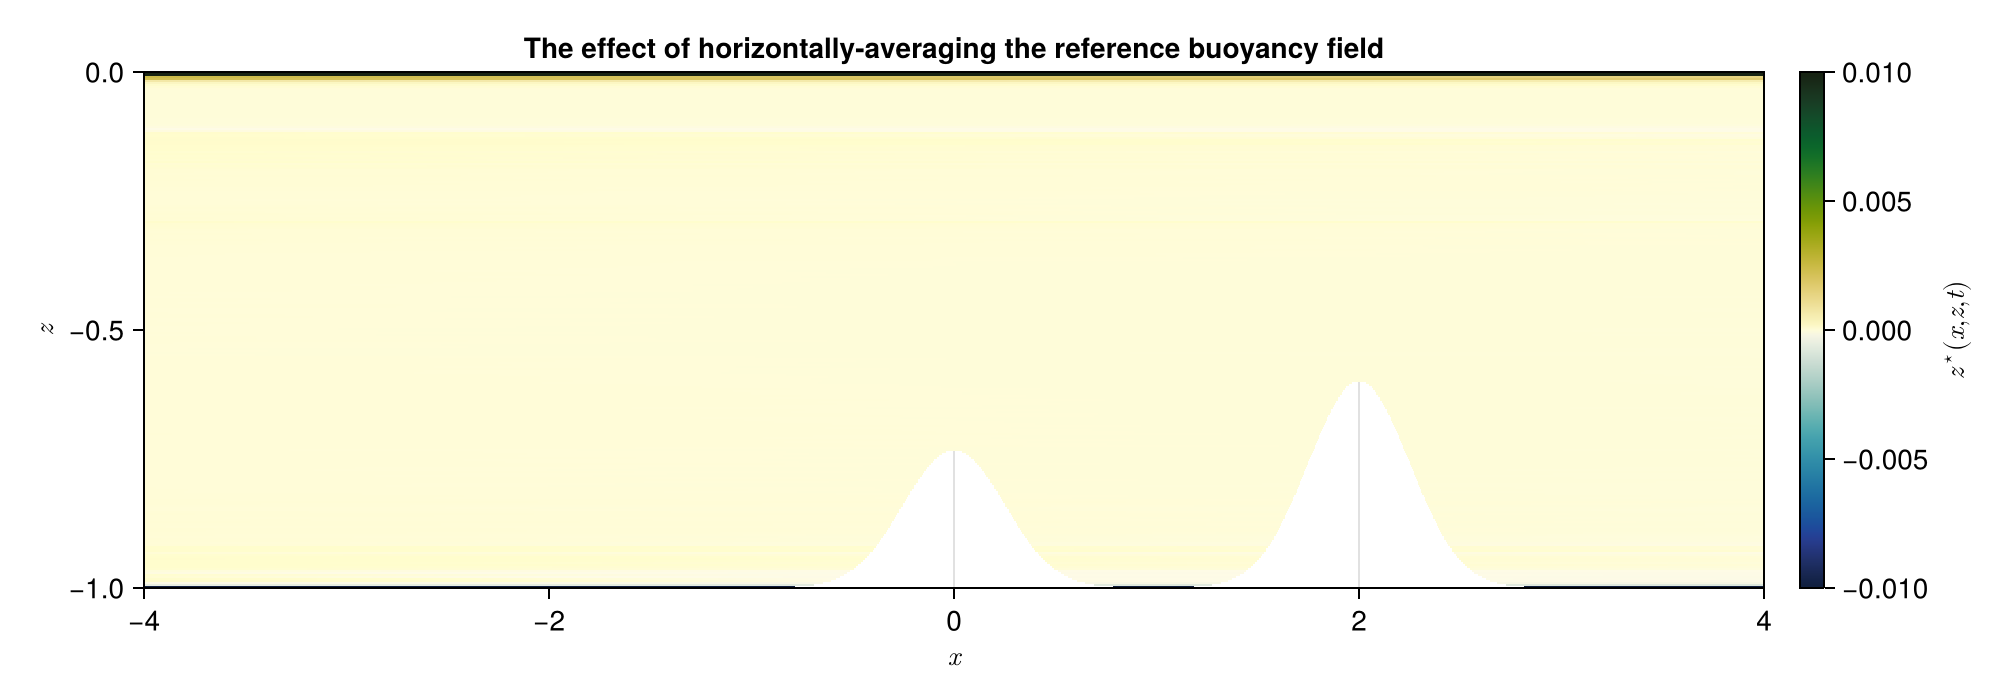

In [26]:
f = Figure(size=(1000, 350))
ax = Axis(f[1,1], xlabel=L"$x$", ylabel=L"$z$", title="The effect of horizontally-averaging the reference buoyancy field")
hm = heatmap!(ax, ds["xC"][5:end-4], ds["zC"][5:end-4], (b̄_ref - b_ref)[:,Ny÷2,:], colorrange = (-1e-2, 1e-2), colormap = :delta)
Colorbar(f[1,2], hm, label=L"$z^{\star}(x,z,t)$");
f

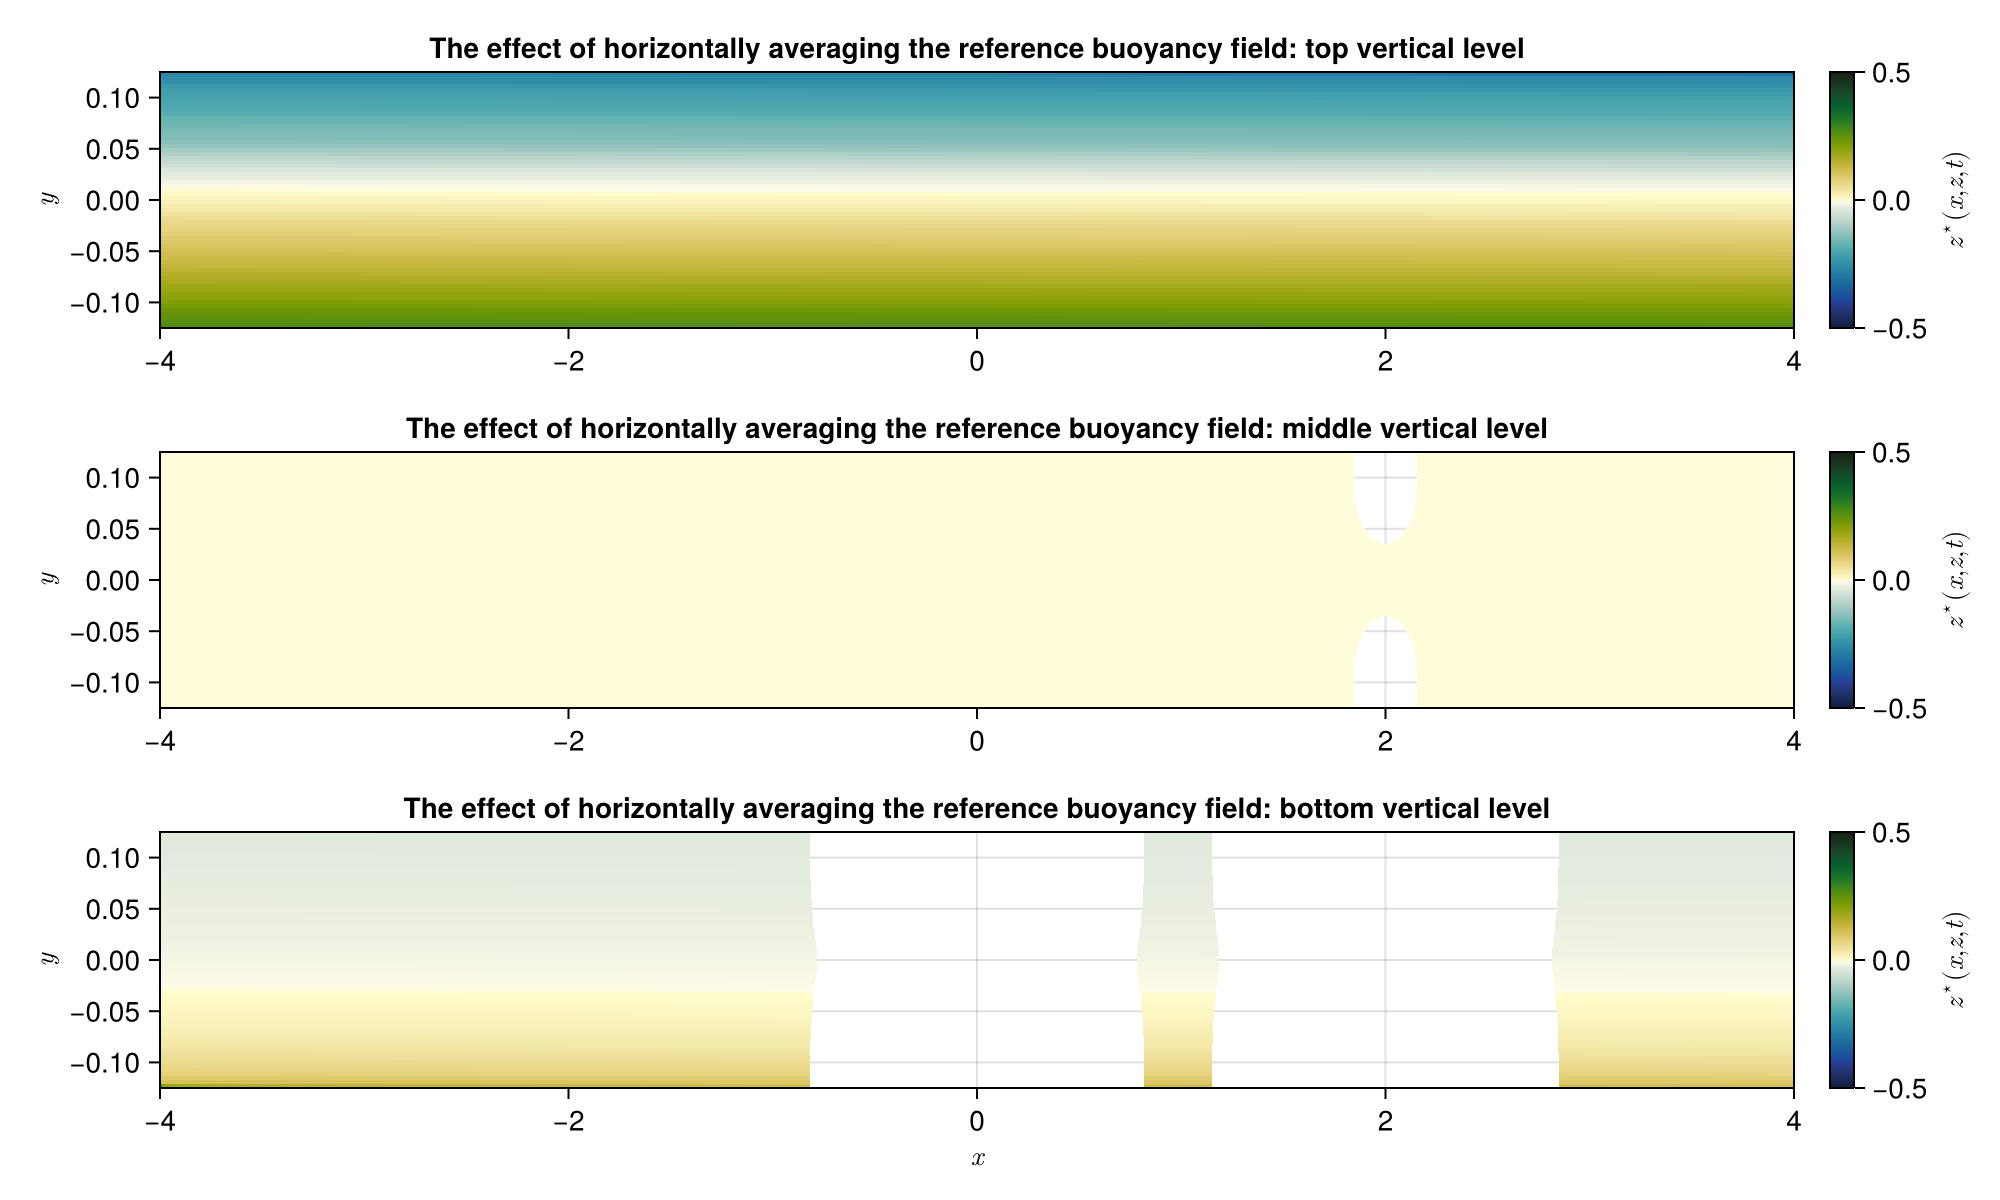

In [27]:
f = Figure(size=(1000, 600))
ax = Axis(f[1,1], ylabel=L"$y$", title="The effect of horizontally averaging the reference buoyancy field: top vertical level")
hm = heatmap!(ax, ds["xC"][5:end-4], ds["yC"][5:end-4], (b̄_ref - b_ref)[:,:,end], colorrange = (-0.5, 0.5), colormap = :delta)
Colorbar(f[1,2], hm, label=L"$z^{\star}(x,z,t)$");

ax = Axis(f[2,1], ylabel=L"$y$", title="The effect of horizontally averaging the reference buoyancy field: middle vertical level")
hm = heatmap!(ax, ds["xC"][5:end-4], ds["yC"][5:end-4], (b̄_ref - b_ref)[:,:,Nz÷2], colorrange = (-0.5, 0.5), colormap = :delta)
Colorbar(f[2,2], hm, label=L"$z^{\star}(x,z,t)$");

ax = Axis(f[3,1], xlabel=L"$x$", ylabel=L"$y$", title="The effect of horizontally averaging the reference buoyancy field: bottom vertical level")
hm = heatmap!(ax, ds["xC"][5:end-4], ds["yC"][5:end-4], (b̄_ref - b_ref)[:,:,1], colorrange = (-0.5, 0.5), colormap = :delta)
Colorbar(f[3,2], hm, label=L"$z^{\star}(x,z,t)$");

f